In [17]:
%load_ext autoreload

%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from plot_images import plot_images
from tools import load_json, read_yaml_config, export_annos, final_join, filter_by_csv, assign_viewpoints
import os
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Load data

In [19]:
config_file_path = 'configs/config.yaml'
species = 'whaleshark'
config = read_yaml_config(config_file_path, species)
print(config)

train_anno_path = config["train_anno_path"]
val_anno_path = config["val_anno_path"]
test_anno_path = config["test_anno_path"]


train_images_dir = config["train_images_dir"]

excluded_viewpoints = config['excluded_viewpoints']

train_data = load_json(train_anno_path)
val_data = load_json(val_anno_path)
test_data = load_json(test_anno_path)


dfa_train = pd.DataFrame(train_data['annotations'])
dfi_train = pd.DataFrame(train_data['images'])

dfi_train = dfi_train.drop_duplicates(keep='first')

assert not dfi_train.astype(str).duplicated().any()

dfa_val = pd.DataFrame(val_data['annotations'])
dfi_val = pd.DataFrame(val_data['images'])
dfi_val = dfi_val.drop_duplicates(keep='first')


assert not dfi_val.astype(str).duplicated().any()

dfa_test = pd.DataFrame(test_data['annotations'])
dfi_test = pd.DataFrame(test_data['images'])


dfa = pd.concat([dfa_train, dfa_val, dfa_test])
dfi = pd.concat([dfi_train, dfi_val, dfi_test])
dfi = dfi.drop_duplicates(keep='first')

assert not dfi.astype(str).duplicated().any()



merge_on_uuid = 'image_uuid' in dfa.columns and 'uuid' in dfi.columns
if merge_on_uuid:
    print('Merging on image uuid')
    df = dfa.merge(dfi, left_on='image_uuid', right_on='uuid')
else:
    df = dfa.merge(dfi, left_on='image_id', right_on='id')


assert not df.astype(str).duplicated().any()

counts = df.groupby('viewpoint').size()
print(counts)


df['path'] = df['file_name'].apply(lambda x: os.path.join(train_images_dir, x))

assert df['path'].apply(os.path.exists).all()

{'data_dir': '/home/kate/data/coco_whaleshark/coco', 'export_dir': '/home/kate/data/coco_whaleshark/coco/export_annotations', 'train_images_dir': '/home/kate/data/coco_whaleshark/coco/images/test2023', 'train_anno_path': '/home/kate/data/coco_whaleshark/coco/annotations/instances_train2023.json', 'val_anno_path': '/home/kate/data/coco_whaleshark/coco/annotations/instances_val2023.json', 'test_anno_path': '/home/kate/data/coco_whaleshark/coco/annotations/instances_test2023.json', 'excluded_viewpoints': ['front', 'back', 'up', 'down'], 'csv_folder': '/home/kate/data/coco_whaleshark/coco/csvs'}
Series([], dtype: int64)


In [20]:
# Need to create 'species' key in the df. Automatically build this from coco file categories

cat_list = train_data['categories']
df['category_id'] = 0
cat_map = {item['id']: item['name'] for item in cat_list}
df['species'] = df['category_id'].map(cat_map)

cat_map

{0: 'rhincodon_typus', 1: 'whaleshark'}

7290


<AxesSubplot:>

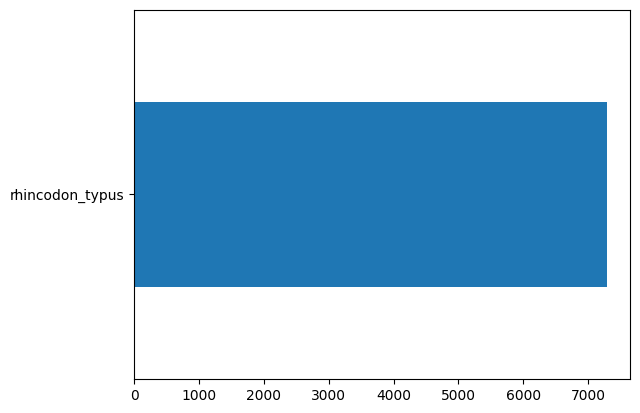

In [21]:
print(len(df))
df['species'].value_counts().plot(kind='barh')


In [22]:
# Filter by csv. Support multiple files
from split import apply_filters
csv_folder = config['csv_folder']
if os.path.exists(csv_folder):
    # Define column names and merge columns for CSV filtering and merging
    csv_column_names = ['annotation_uuid', 'viewpoint_y']
    merge_cols = ['annotation_uuid', 'viewpoint_y']

    df = filter_by_csv(df, csv_folder, csv_column_names=csv_column_names, merge_columns=merge_cols)

    # Replace 'viewpoint' values where 'viewpoint_y' is not null
    df.loc[df["viewpoint_y"].notna(), "viewpoint"] = df.loc[df["viewpoint_y"].notna(), "viewpoint_y"]
    df = df.drop("viewpoint_y", axis=1)

    # Remove rows where 'name' is '____'
    df = df[df['name'] != '____']
    df = df.reset_index(drop=True)


# Assign viewpoints to "right" and "left" and remove excluded viewpoints
df = assign_viewpoints(df, excluded_viewpoints)

# Calculate and print the counts of each 'viewpoint' category
counts = df.groupby('viewpoint').size()
print(counts)


Total annotations in all CSV files: 7291
Unique annotations in all CSV files: 7291
Annotations after CSV merge: 7290
viewpoint
left     4501
right    2789
dtype: int64


In [23]:
df['name_viewpoint'] = df['name'] + '-' + df['viewpoint']
df['species_viewpoint'] = df['species'] + '-' + df['viewpoint']

In [24]:
# Remove singletons
df = apply_filters(df, 'name_viewpoint', None, min_df=2)

print("Annotations after removing singletons:", len(df))

counts = df.groupby('viewpoint').size()
print(counts)

Annotations after removing singletons: 6955
viewpoint
left     4307
right    2648
dtype: int64


6955
647


<AxesSubplot:>

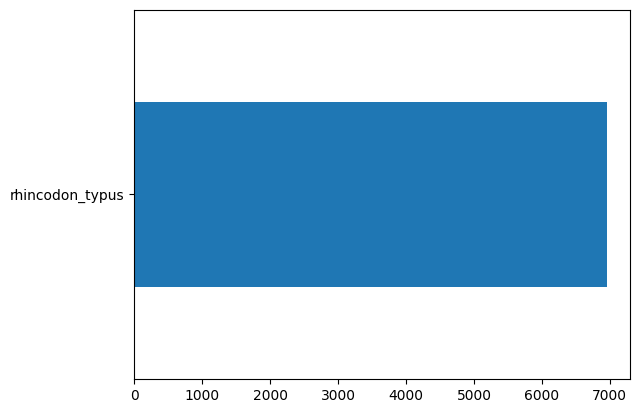

In [25]:
print(len(df))

print(len(df['name_viewpoint'].unique()))

df['species'].value_counts().plot(kind='barh')


In [26]:
# Make sure merging did not create duplicates
assert not df.astype(str).duplicated().any()

### Visualize

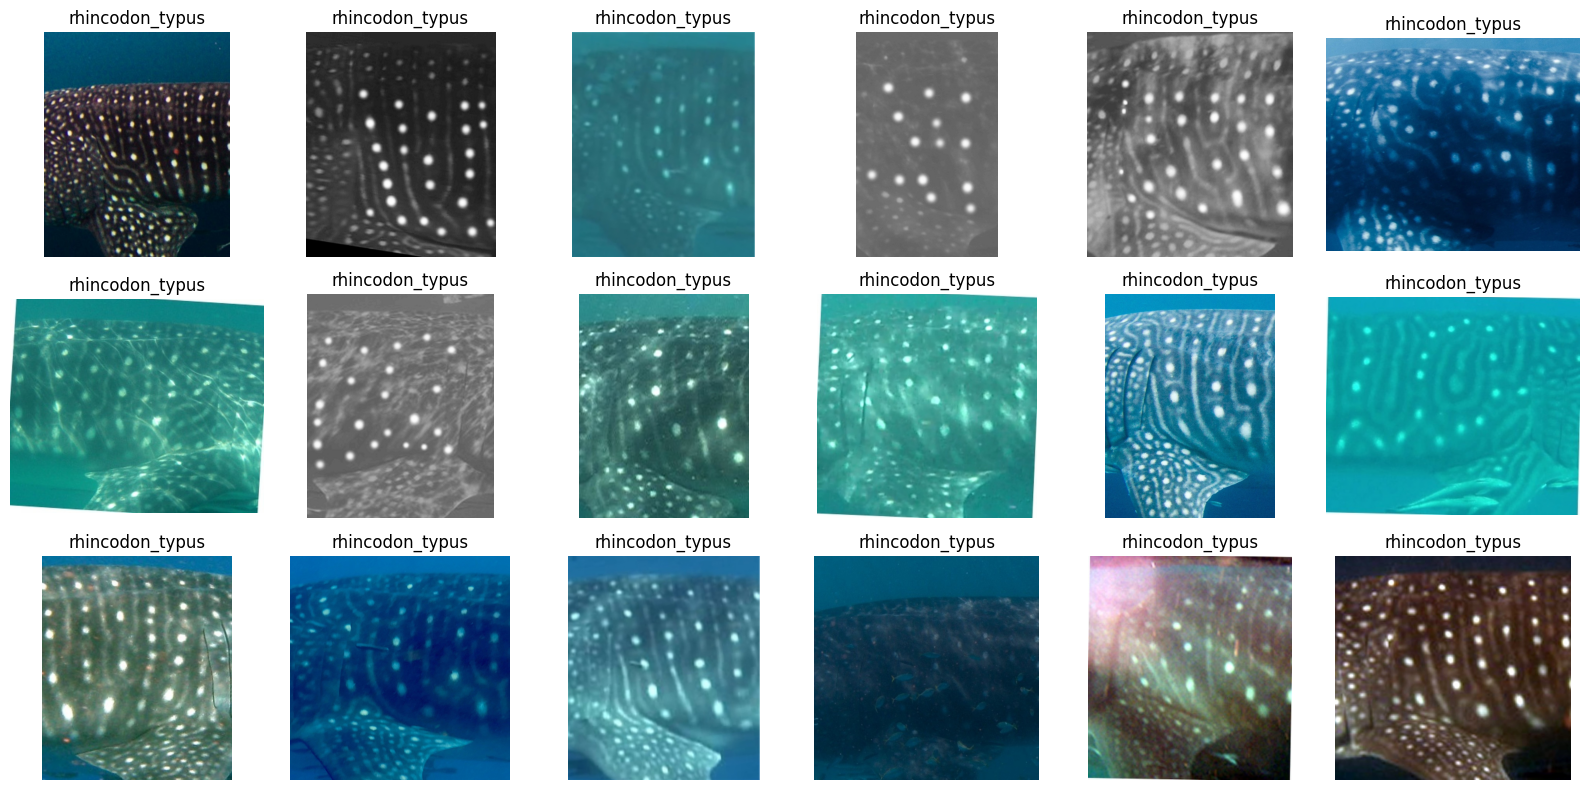

Filter value: A-302-left
Length: 39


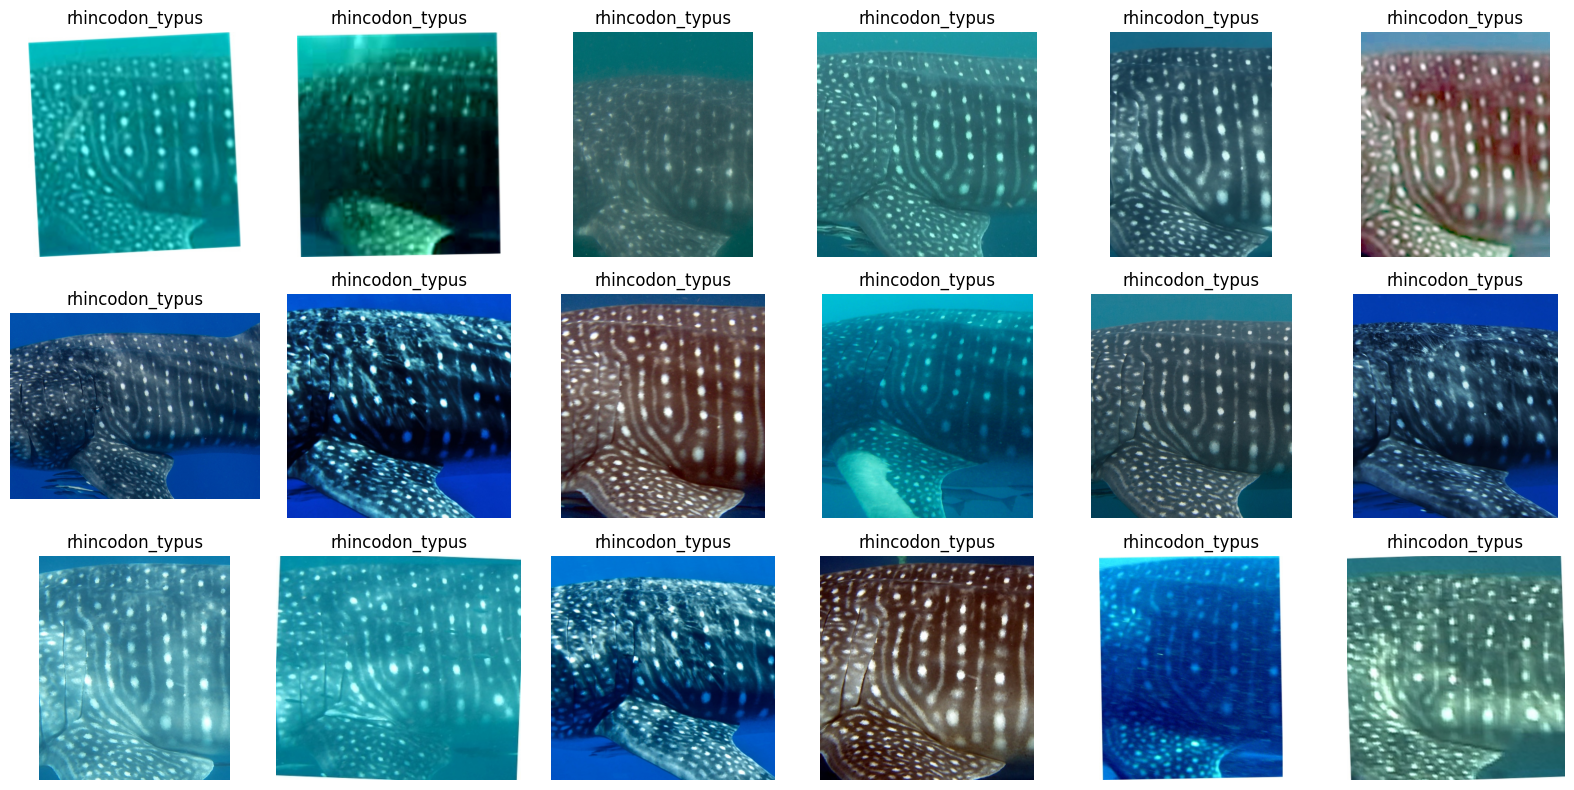

In [27]:
for species in df['species'].unique():
    plot_images(df, species=species, crop_bbox=True)


# Possible use to check images per class:
for species in df['species'].unique():
    random_class = df["name_viewpoint"].sample().values[0]
    plot_images(df, species=species, filter_key="name_viewpoint", filter_value=random_class, crop_bbox=True)

### Split
- The split 

In [28]:
from split import split_df

In [29]:
print(df['species'].value_counts())
print(len(df['name_viewpoint'].unique()))

rhincodon_typus    6955
Name: species, dtype: int64
647


In [31]:
# apply split function
df_tr, df_te, df_val = split_df(df, train_ratio=0.7, unseen_ratio=0.5, is_val=True, stratify_col='name_viewpoint', print_key='name_viewpoint', verbose=True)



Filtering...
Before filtering: 6955 annotations
After filtering: 6955 annotations

--------------------------------------------------

Calculating stats for combined subsets
** cross-set stats **

- Counts: 
Number of annotations - total:  6955
number of individuals in train:  369
number of annotations in train:  4720

number of individuals in test:  278
number of annotations in test:  1089

number of individuals in val:  278
number of annotations in val:  1146

train ratio:  0.6786484543493889
average number of annotations per individual in train: 12.79
average number of annotations per individual in test: 3.92
average number of annotations per individual in val: 4.12

- New individuals: 
number of new (unseen) individuals in test: 144
ratio of new names to all individuals in test: 0.52

number of new (unseen) individuals in val: 134
ratio of new names to all individuals in val: 0.48
- Individuals in sets: 
number of overlapping individuals in train & test: 134
ratio of overlapping na

In [57]:
# apply filtering to split data
from split import apply_filters, intersect_stats

df_tr_filtered = apply_filters(df_tr, 'name_viewpoint', max_df=20, min_df=2)
df_te_filtered = apply_filters(df_te, 'name_viewpoint', max_df=10, min_df=2)
df_val_filtered = apply_filters(df_val, 'name_viewpoint', max_df=10, min_df=2)

intersect_stats(df_tr_filtered, df_te_filtered, df_val_filtered, key='name_viewpoint')

** cross-set stats **

- Counts: 
Number of annotations - total:  5604
number of individuals in train:  369
number of annotations in train:  3380

number of individuals in test:  278
number of annotations in test:  1116

number of individuals in val:  278
number of annotations in val:  1108

train ratio:  0.6031406138472519
average number of annotations per individual in train: 9.16
average number of annotations per individual in test: 4.01
average number of annotations per individual in val: 3.99

- New individuals: 
number of new (unseen) individuals in test: 143
ratio of new names to all individuals in test: 0.51

number of new (unseen) individuals in val: 135
ratio of new names to all individuals in val: 0.49
- Individuals in sets: 
number of overlapping individuals in train & test: 135
ratio of overlapping names to total individuals in train: 0.37
ratio of overlapping names to total individuals in test: 0.49
Number of annotations in train for overlapping individuals with test:  77

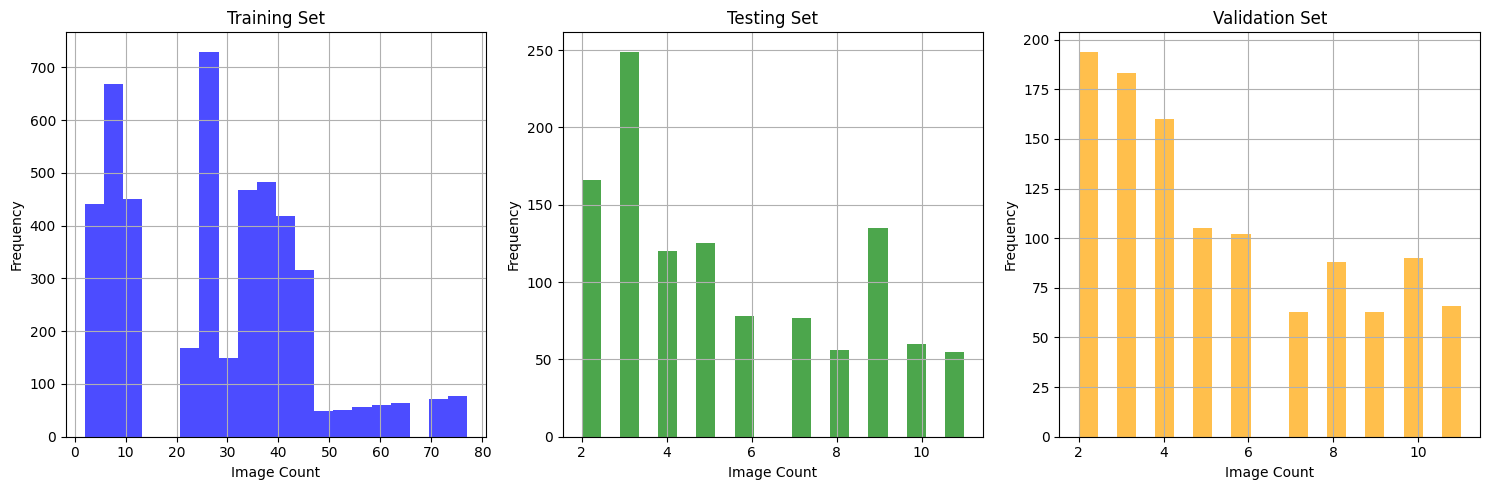

In [58]:
# Plot data

from tools import add_image_count

# Add 'image_count" column
df_tr = add_image_count(df_tr, 'name_viewpoint')
df_te = add_image_count(df_te, 'name_viewpoint')
df_val = add_image_count(df_val, 'name_viewpoint')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot histograms for each DataFrame in a separate subplot
df_tr['image_count'].hist(ax=axes[0], bins=20, color='blue', alpha=0.7)
axes[0].set_title('Training Set')
axes[0].set_xlabel('Image Count')
axes[0].set_ylabel('Frequency')

df_te['image_count'].hist(ax=axes[1], bins=20, color='green', alpha=0.7)
axes[1].set_title('Testing Set')
axes[1].set_xlabel('Image Count')
axes[1].set_ylabel('Frequency')

df_val['image_count'].hist(ax=axes[2], bins=20, color='orange', alpha=0.7)
axes[2].set_title('Validation Set')
axes[2].set_xlabel('Image Count')
axes[2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

### Generate files to be exported






In [59]:
dfa_tr, dfi_tr = final_join(df_tr, dfa, dfi, df)
dfa_te, dfi_te = final_join(df_te, dfa, dfi, df)
dfa_val, dfi_val = final_join(df_val, dfa, dfi, df)

### Final data distribution sanity checks

<AxesSubplot:>

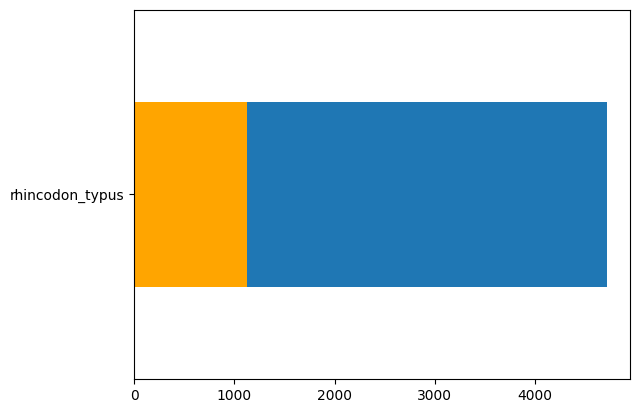

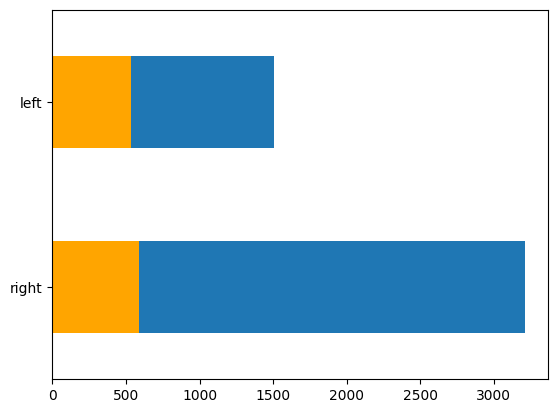

In [60]:
fig, ax = plt.subplots()
# ax2 = ax.twiny()
dfa_tr['species'].value_counts().plot(kind='barh', ax=ax)
dfa_te['species'].value_counts().plot(kind='barh', ax=ax, color='orange')

fig, ax = plt.subplots()
# ax2 = ax.twiny()
dfa_tr['viewpoint'].value_counts().plot(kind='barh', ax=ax)
dfa_te['viewpoint'].value_counts().plot(kind='barh', ax=ax, color='orange')

In [24]:
assert not dfa_tr['uuid'].duplicated().any()

### Export

In [119]:
export_dir = config["export_dir"]
os.makedirs(export_dir, exist_ok=True)


def coco_path(split): return f"instances_{split}2024.json"


train_coco_path = os.path.join(export_dir, coco_path('train'))
val_coco_path = os.path.join(export_dir, coco_path('val'))
test_coco_path = os.path.join(export_dir, coco_path('test'))

export_annos(dfa_tr, dfi_tr, train_coco_path)
export_annos(dfa_val, dfi_val, val_coco_path)
export_annos(dfa_te, dfi_te, test_coco_path)

out_path /home/kate/data/zebra/gzcd_export/export_annotations/instances_train2024.json
shapes:  (2648, 9) (2648, 4)
len(images_list) 2648
len(annos_list) 2648
out_path /home/kate/data/zebra/gzcd_export/export_annotations/instances_val2024.json
shapes:  (643, 9) (643, 4)
len(images_list) 643
len(annos_list) 643
out_path /home/kate/data/zebra/gzcd_export/export_annotations/instances_test2024.json
shapes:  (643, 9) (643, 4)
len(images_list) 643
len(annos_list) 643
